In [ ]:
!nvidia-smi

Sat Apr 24 23:53:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |   1432MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/DL_Assignment/DataSet/earth_data.zip" -d "./"
!ls

Archive:  /content/gdrive/My Drive/DL_Assignment/DataSet/earth_data.zip
  inflating: ./earth_data.h5         
earth_data.h5  gdrive  sample_data


# **All Imports**

In [ ]:
# import the necessary packages
import gc
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Activation
from IPython.display import display
from keras.utils import plot_model

**Set Seeds**

In [ ]:
tf.random.set_seed(207241)
np.random.seed(207241)

# **Read DataSet**

In [ ]:
#Read data from hdf5 file
import numpy as np
import h5py

def loadDataH5():        
    with h5py.File('earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))        
    return trainX, trainY, valX, valY

In [ ]:
#Get All details about data
def get_working_data():
  trainX, trainY, valX, valY = loadDataH5()
  training_data_count,height,width,depth = trainX.shape
  unique_val, class_dist = np.unique(trainY,return_counts=True)
  print("Number of classes:",unique_val.shape[0])
  print("Class Value:",unique_val)
  print("Class distribution:",class_dist)
  print(trainX.shape,trainY.shape)
  print(valX.shape,valY.shape)
  trainX = trainX.astype("float") / 255.0
  valX = valX.astype("float") / 255.0
  return trainX, trainY, valX, valY,(height,width,depth,unique_val.shape[0])

g_trainX,g_trainY,g_valX,g_valY,(g_height,g_width,g_depth,g_classes) = \
                        get_working_data()

Number of classes: 9
Class Value: [0 1 2 3 4 5 6 7 8]
Class distribution: [2400 2400 2400 2000 2000 1600 2000 2400 2000]
(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


`As per number of instances for each class displayed above, the data set has class imbalance problem `

---



# **Utility Classes**

In [ ]:
#Stores the performance matrix for each model run
class MODEL_PERFORMANCE:

  def __init__(self, val_loss,val_acc,train_loss,train_acc):
    self.val_loss = val_loss
    self.val_acc  = val_acc
    self.train_loss = train_loss
    self.train_acc = train_acc

class RECORD:

  def __init__(self):
    self.store = {}    

  def add_entry(self,name,performance):
    self.store[name] = performance

#Global object 
g_record_v1 = RECORD()
g_record_v2 = RECORD()
g_record_v3 = RECORD()

# **Plots**
Performance matrix

Comaprision

In [ ]:
# Performance plot for a model depicting training/validation loss/accuracy

def plot_model_performance(name,history,model_history):
  plt.style.use("ggplot")
  plt.figure()
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
  print("Model Performance Summary:")
  best_val_accuracy = max(history.history["val_accuracy"])
  print("Best Validation Accuracy: ",best_val_accuracy," at EPOCH:",\
        history.history["val_accuracy"].index(best_val_accuracy))
  min_val_loss = min(history.history["val_loss"])
  print("Min validation loss:",min_val_loss," at EPOCH:", \
        history.history["val_loss"].index(min_val_loss))
  
  #Store the above performance matrix
  model_history.add_entry(name,MODEL_PERFORMANCE( \
                             val_acc = history.history["val_accuracy"], \
                            val_loss = history.history["val_loss"], \
                            train_loss = history.history["loss"],
                            train_acc = history.history["accuracy"]))

Plot for comparing two model

In [ ]:
from matplotlib.pyplot import draw, show

def compare_model_performance_with_lrs(model_name):
    
    compare_model_performance(model_name, model_name, model_name,\
                              model2_history = g_record_v2)
    
def compare_model_performance_with_augmentation(model_name):

    compare_model_performance(model_name, model_name, \
                              "Augmented " + model_name,\
                              model2_history = g_record_v3) 
    
    
def compare_model_performance_with_another(model1_name,model2_name):
    compare_model_performance(model1_name, model2_name, \
                      " 1: " + model1_name+" 2:"+model2_name,\
                              model2_history = g_record_v1)    

    

def compare_model_performance(model1_name,model2_name,title_suffix,\
                              model1_history = \
                              g_record_v1,model2_history = g_record_v1):
  
  mode1_per = model1_history.store[model1_name]
  mode2_per = model2_history.store[model2_name]

  model1_val_loss = mode1_per.val_loss
  model1_val_acc = mode1_per.val_acc
  model1_train_loss = mode1_per.train_loss
  model1_train_acc = mode1_per.train_acc
  
  model2_val_loss = mode2_per.val_loss
  model2_val_acc = mode2_per.val_acc
  model2_train_loss = mode2_per.train_loss
  model2_train_acc = mode2_per.train_acc

  plt.style.use("ggplot")
  plt.figure(figsize=(40, 10))
  fig, axes = plt.subplots(2, 2)
 
  epoch1_ran = len(model1_val_loss)
  epoch2_ran = len(model2_val_loss)

  axes[0][0].set_xlabel("EPOCH #")
  axes[0][0].set_ylabel("Loss")
  axes[0][0].set(title = title_suffix)
  axes[0][0].plot(np.arange(0,epoch1_ran),model1_val_loss,label="1: Val Loss")
  axes[0][0].plot(np.arange(0,epoch2_ran),model2_val_loss,label="2: Val Loss")
  axes[0][0].legend()

  axes[0][1].set_xlabel("EPOCH #")
  axes[0][1].set_ylabel("Accuracy")
  #axes[0][1].set(title = title_suffix)
  axes[0][1].plot(np.arange(0,epoch1_ran),model1_val_acc,label="1: Val Acc")
  axes[0][1].plot(np.arange(0,epoch2_ran),model2_val_acc,label="2: Val Acc")
  axes[0][1].legend()

  axes[1][0].set_xlabel("EPOCH #")
  axes[1][0].set_ylabel("Loss")
  #axes[1][0].set(title = 'Train Loss  '+ title_suffix)
  axes[1][0].plot(np.arange(0,epoch1_ran),model1_train_loss,label="1: Train Loss")
  axes[1][0].plot(np.arange(0,epoch2_ran),model2_train_loss,label="2: Train Loss")
  axes[1][0].legend()

  axes[1][1].set_xlabel("EPOCH #")
  axes[1][1].set_ylabel("Accuracy")
  #axes[1][1].set(title = 'Train Acc  '+ title_suffix)
  axes[1][1].plot(np.arange(0,epoch1_ran),model1_train_acc,label="1: Train Acc")
  axes[1][1].plot(np.arange(0,epoch2_ran),model2_train_acc,label="2: Train Acc")
  axes[1][1].legend()
  #fig.tight_layout()
  draw()
  plt.show()

# **Wrapper function for building and executing model**


1.   Nomal Model
2.   Model using agumented input



In [ ]:
# This function used for building,compiling and testing the model
def call_model(model_name,callback_obj,input_data = (g_trainX,g_trainY, \
                                                     g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 70,optimizer_obj=None, \
               model_history = g_record_v1):
  NUM_EPOCHS = iterations
  trainX,trainY,valX,valY = input_data
  model = model_name(inputshape,classes)
  tf.random.set_seed(207241)

  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(lr=0.01)

  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(trainX, trainY, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = callback_obj)  
  
  plot_model_performance(model.name,history,model_history)  
  #Invoking garbage collection manually helps allivaiting the problem of 
  # high RAM usage in
  gc.collect()

In [ ]:
#This function use generator object 
def call_model_with_augmentation(model_name,callback_obj,generator_obj,
               input_data = (g_trainX,g_trainY, g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 70,optimizer_obj=None, \
               model_history = g_record_v3, batch_size = 32):
  NUM_EPOCHS = iterations
  trainX,trainY,valX,valY = input_data
  model = model_name(inputshape,classes)
  tf.random.set_seed(207241)
  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(lr=0.01)
  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(generator_obj, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = callback_obj, \
                    steps_per_epoch=len(trainX)/ batch_size)  
  
  plot_model_performance(model.name,history,model_history)  
  gc.collect()

# **Callbacks**


1.   Early Stopping on Minimum Validation Loss
2.   Checkpointing on Minimum Validation Loss
3.   Learning Rate Schedular



In [ ]:
def get_early_stoping_cb_on_min_val_loss(patience_num = 4):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=1, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_min_val_loss(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <20:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=1)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_min_val_loss(file_name),
          get_model_learning_rate_cb()]

# **Model**

In [ ]:
#Base Model
def BaseLine_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "BaseLine_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),        
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

In [ ]:
def Baseline_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "Baseline_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

In [ ]:
def CONV2_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV2_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

In [ ]:
def CONV3_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV3_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model


In [ ]:
def CONV4_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV4_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

In [ ]:
def CONV4_d512_drop_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV4_d512_drop_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

In [ ]:
def CONV4_sp_d512_drop_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV4_sp_d512_drop_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "BaseLine_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


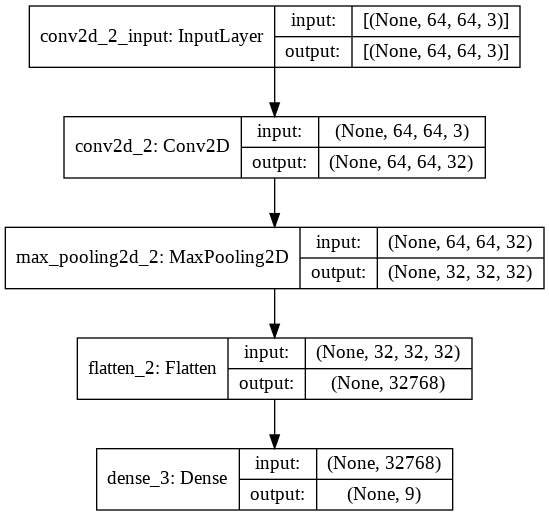

Epoch 1/70
600/600 [==============================] - 3s 4ms/step - loss: 1.8432 - accuracy: 0.3105 - val_loss: 1.4679 - val_accuracy: 0.4321
Epoch 2/70
600/600 [==============================] - 2s 4ms/step - loss: 1.4263 - accuracy: 0.4711 - val_loss: 1.3456 - val_accuracy: 0.4869
Epoch 3/70
600/600 [==============================] - 2s 3ms/step - loss: 1.2766 - accuracy: 0.5361 - val_loss: 1.1679 - val_accuracy: 0.5660
Epoch 4/70
600/600 [==============================] - 2s 4ms/step - loss: 1.1264 - accuracy: 0.5907 - val_loss: 1.0519 - val_accuracy: 0.6527
Epoch 5/70
600/600 [==============================] - 2s 3ms/step - loss: 1.0745 - accuracy: 0.6155 - val_loss: 1.0583 - val_accuracy: 0.6198
Epoch 6/70
600/600 [==============================] - 2s 4ms/step - loss: 1.0105 - accuracy: 0.6353 - val_loss: 0.9680 - val_accuracy: 0.6587
Epoch 7/70
600/600 [==============================] - 2s 4ms/step - loss: 0.9511 - accuracy: 0.6575 - val_loss: 1.0283 - val_accuracy: 0.6119
Epoch 

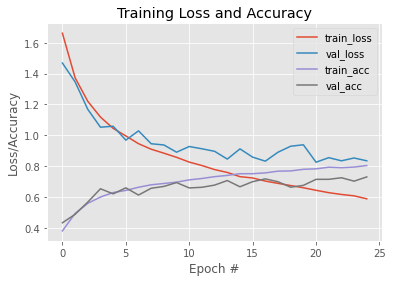

Model Performance Summary:
Best Validation Accuracy:  0.7295833230018616  at EPOCH: 24
Min validation loss: 0.8248214721679688  at EPOCH: 20


In [ ]:
call_model(BaseLine_CNN,get_basic_callback())

Model: "Baseline_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 4617      
Total params: 16,783,241
Trainable params: 16,783,241
Non-trainable params: 0
_________________________________________________________________
None


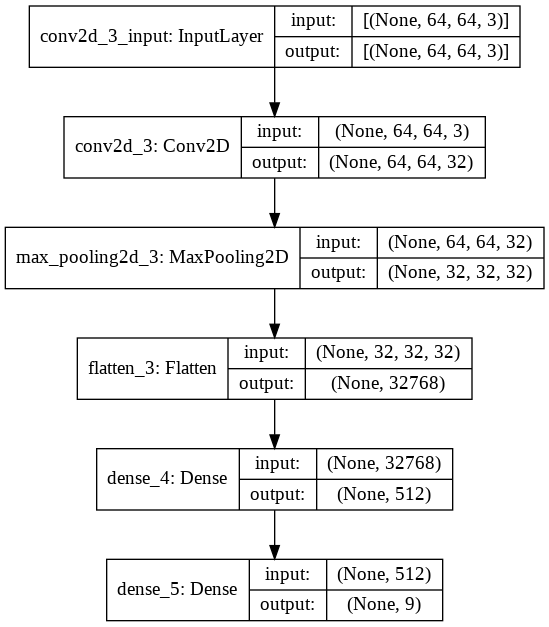

Epoch 1/70
600/600 [==============================] - 4s 6ms/step - loss: 1.8401 - accuracy: 0.3095 - val_loss: 1.5129 - val_accuracy: 0.4275
Epoch 2/70
600/600 [==============================] - 3s 6ms/step - loss: 1.4324 - accuracy: 0.4692 - val_loss: 1.3923 - val_accuracy: 0.4758
Epoch 3/70
600/600 [==============================] - 3s 5ms/step - loss: 1.3042 - accuracy: 0.5221 - val_loss: 1.1353 - val_accuracy: 0.5815
Epoch 4/70
600/600 [==============================] - 3s 6ms/step - loss: 1.1387 - accuracy: 0.5858 - val_loss: 1.0263 - val_accuracy: 0.6544
Epoch 5/70
600/600 [==============================] - 3s 6ms/step - loss: 1.0637 - accuracy: 0.6153 - val_loss: 1.0979 - val_accuracy: 0.5938
Epoch 6/70
600/600 [==============================] - 3s 6ms/step - loss: 0.9621 - accuracy: 0.6482 - val_loss: 0.8788 - val_accuracy: 0.6808
Epoch 7/70
600/600 [==============================] - 3s 6ms/step - loss: 0.8812 - accuracy: 0.6793 - val_loss: 0.9278 - val_accuracy: 0.6254
Epoch 

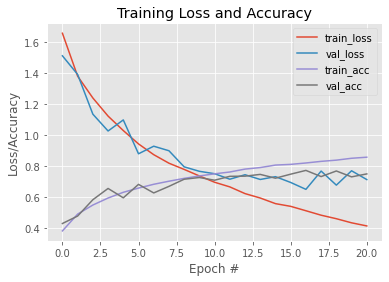

Model Performance Summary:
Best Validation Accuracy:  0.7712500095367432  at EPOCH: 16
Min validation loss: 0.6485788226127625  at EPOCH: 16


In [ ]:
call_model(Baseline_d512_CNN,get_basic_callback())

Model: "CONV2_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dense_7 (Dense)              (None, 9)              

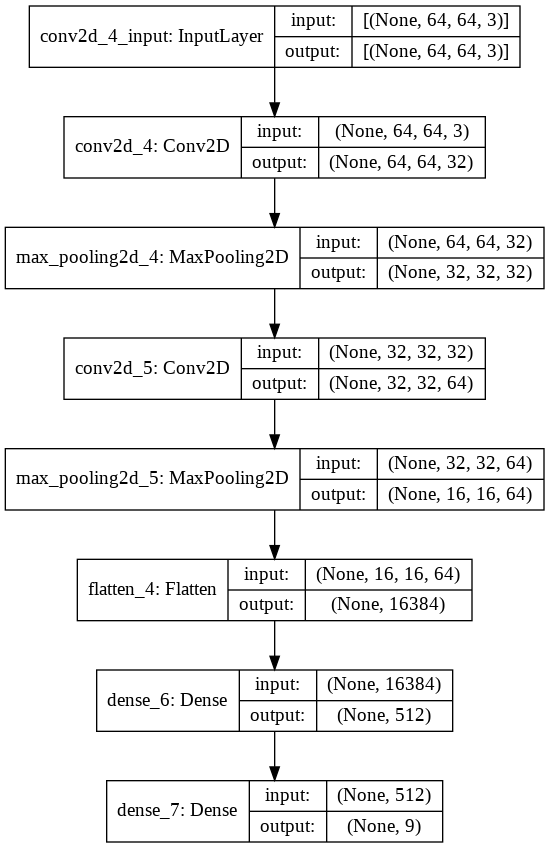

Epoch 1/70
600/600 [==============================] - 4s 6ms/step - loss: 1.9010 - accuracy: 0.2825 - val_loss: 1.5318 - val_accuracy: 0.3967
Epoch 2/70
600/600 [==============================] - 4s 6ms/step - loss: 1.4195 - accuracy: 0.4706 - val_loss: 1.4211 - val_accuracy: 0.4567
Epoch 3/70
600/600 [==============================] - 4s 6ms/step - loss: 1.2561 - accuracy: 0.5426 - val_loss: 1.0542 - val_accuracy: 0.6135
Epoch 4/70
600/600 [==============================] - 4s 6ms/step - loss: 1.0679 - accuracy: 0.6108 - val_loss: 0.9421 - val_accuracy: 0.6679
Epoch 5/70
600/600 [==============================] - 4s 6ms/step - loss: 0.9782 - accuracy: 0.6404 - val_loss: 1.0073 - val_accuracy: 0.6125
Epoch 6/70
600/600 [==============================] - 4s 6ms/step - loss: 0.8742 - accuracy: 0.6769 - val_loss: 0.7857 - val_accuracy: 0.7077
Epoch 7/70
600/600 [==============================] - 4s 6ms/step - loss: 0.8035 - accuracy: 0.7000 - val_loss: 0.8491 - val_accuracy: 0.6633
Epoch 

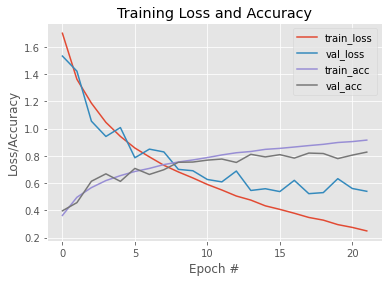

Model Performance Summary:
Best Validation Accuracy:  0.8272916674613953  at EPOCH: 21
Min validation loss: 0.5223976373672485  at EPOCH: 17


In [ ]:
call_model(CONV2_d512_CNN,get_basic_callback())

Model: "CONV3_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)           

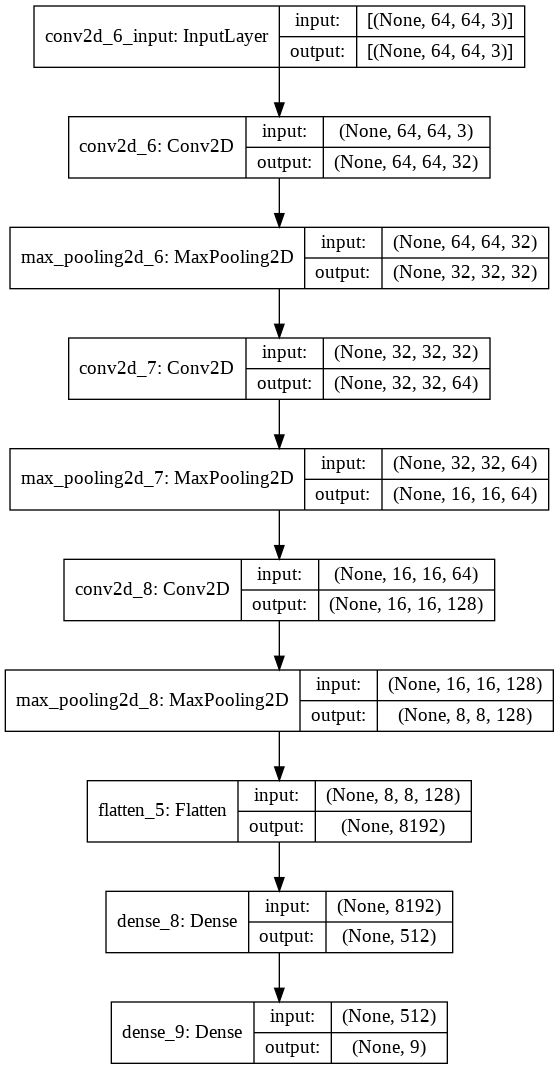

Epoch 1/70
600/600 [==============================] - 4s 7ms/step - loss: 1.9819 - accuracy: 0.2615 - val_loss: 1.4792 - val_accuracy: 0.4423
Epoch 2/70
600/600 [==============================] - 4s 6ms/step - loss: 1.4407 - accuracy: 0.4688 - val_loss: 1.4679 - val_accuracy: 0.4387
Epoch 3/70
600/600 [==============================] - 4s 6ms/step - loss: 1.2744 - accuracy: 0.5329 - val_loss: 1.1027 - val_accuracy: 0.5788
Epoch 4/70
600/600 [==============================] - 4s 6ms/step - loss: 1.0986 - accuracy: 0.6008 - val_loss: 0.9832 - val_accuracy: 0.6510
Epoch 5/70
600/600 [==============================] - 4s 6ms/step - loss: 1.0008 - accuracy: 0.6310 - val_loss: 1.2677 - val_accuracy: 0.5350
Epoch 6/70
600/600 [==============================] - 4s 6ms/step - loss: 0.8862 - accuracy: 0.6785 - val_loss: 0.7833 - val_accuracy: 0.7121
Epoch 7/70
600/600 [==============================] - 4s 6ms/step - loss: 0.8138 - accuracy: 0.7003 - val_loss: 0.8454 - val_accuracy: 0.6765
Epoch 

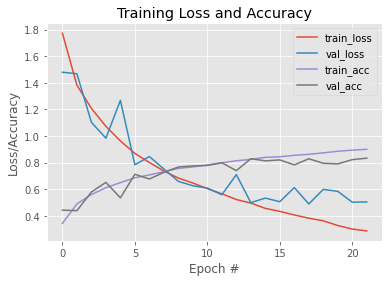

Model Performance Summary:
Best Validation Accuracy:  0.8333333134651184  at EPOCH: 21
Min validation loss: 0.48891016840934753  at EPOCH: 17


In [ ]:
call_model(CONV3_d512_CNN,get_basic_callback())

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)      

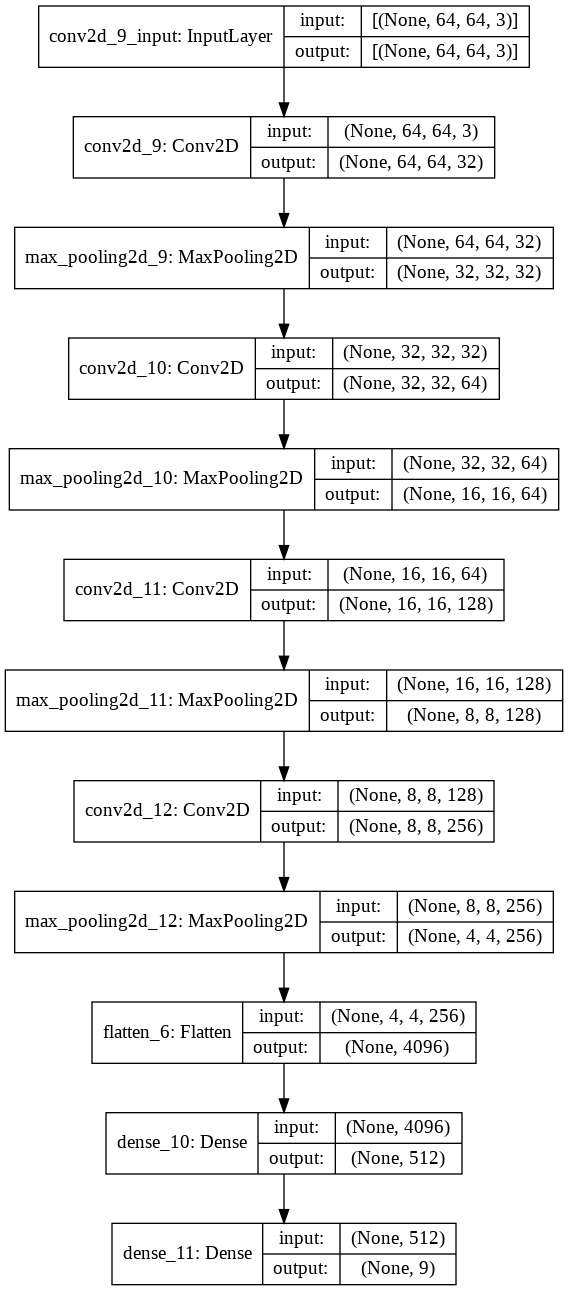

Epoch 1/70
600/600 [==============================] - 5s 7ms/step - loss: 2.0472 - accuracy: 0.2115 - val_loss: 1.6115 - val_accuracy: 0.3500
Epoch 2/70
600/600 [==============================] - 4s 7ms/step - loss: 1.5323 - accuracy: 0.4240 - val_loss: 1.5758 - val_accuracy: 0.4010
Epoch 3/70
600/600 [==============================] - 4s 7ms/step - loss: 1.3298 - accuracy: 0.5126 - val_loss: 1.1422 - val_accuracy: 0.5677
Epoch 4/70
600/600 [==============================] - 4s 7ms/step - loss: 1.1557 - accuracy: 0.5781 - val_loss: 1.0940 - val_accuracy: 0.6052
Epoch 5/70
600/600 [==============================] - 4s 7ms/step - loss: 1.0564 - accuracy: 0.6049 - val_loss: 1.2142 - val_accuracy: 0.5575
Epoch 6/70
600/600 [==============================] - 4s 7ms/step - loss: 0.9360 - accuracy: 0.6559 - val_loss: 0.8467 - val_accuracy: 0.6829
Epoch 7/70
600/600 [==============================] - 4s 7ms/step - loss: 0.8643 - accuracy: 0.6753 - val_loss: 0.9143 - val_accuracy: 0.6415
Epoch 

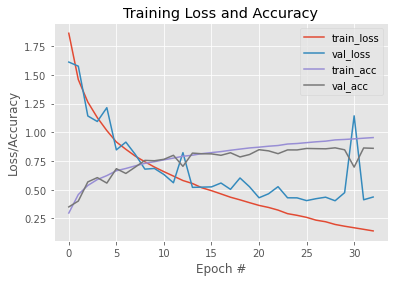

Model Performance Summary:
Best Validation Accuracy:  0.8645833134651184  at EPOCH: 28
Min validation loss: 0.40359362959861755  at EPOCH: 28


In [ ]:
call_model(CONV4_d512_CNN,get_basic_callback())

Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 256) 

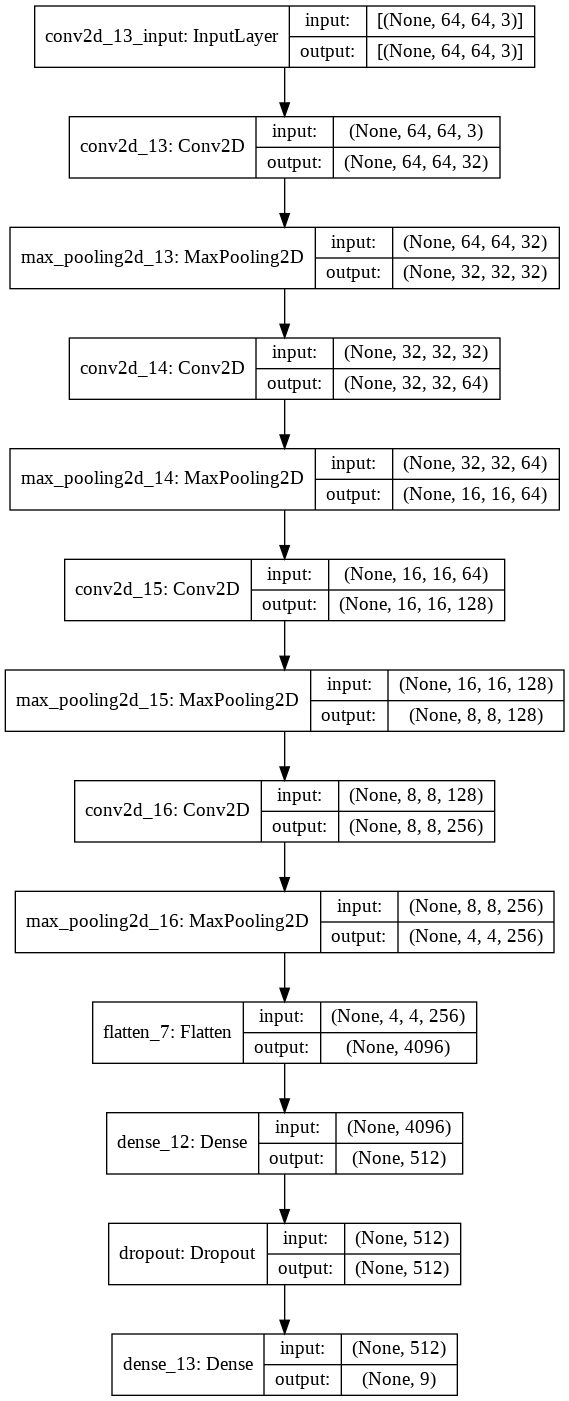

Epoch 1/70
600/600 [==============================] - 5s 7ms/step - loss: 2.0528 - accuracy: 0.2086 - val_loss: 1.5958 - val_accuracy: 0.3565
Epoch 2/70
600/600 [==============================] - 4s 7ms/step - loss: 1.5471 - accuracy: 0.4196 - val_loss: 1.6147 - val_accuracy: 0.3869
Epoch 3/70
600/600 [==============================] - 4s 7ms/step - loss: 1.3496 - accuracy: 0.5030 - val_loss: 1.1414 - val_accuracy: 0.5646
Epoch 4/70
600/600 [==============================] - 4s 7ms/step - loss: 1.1715 - accuracy: 0.5734 - val_loss: 1.0553 - val_accuracy: 0.6215
Epoch 5/70
600/600 [==============================] - 4s 7ms/step - loss: 1.0733 - accuracy: 0.6038 - val_loss: 1.3007 - val_accuracy: 0.5327
Epoch 6/70
600/600 [==============================] - 4s 7ms/step - loss: 0.9608 - accuracy: 0.6494 - val_loss: 0.8542 - val_accuracy: 0.6802
Epoch 7/70
600/600 [==============================] - 4s 7ms/step - loss: 0.8865 - accuracy: 0.6716 - val_loss: 0.9333 - val_accuracy: 0.6360
Epoch 

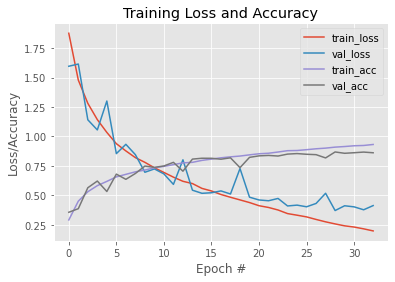

Model Performance Summary:
Best Validation Accuracy:  0.8683333396911621  at EPOCH: 28
Min validation loss: 0.3710472583770752  at EPOCH: 28


In [ ]:
call_model(CONV4_d512_drop_CNN,get_basic_callback())

Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 

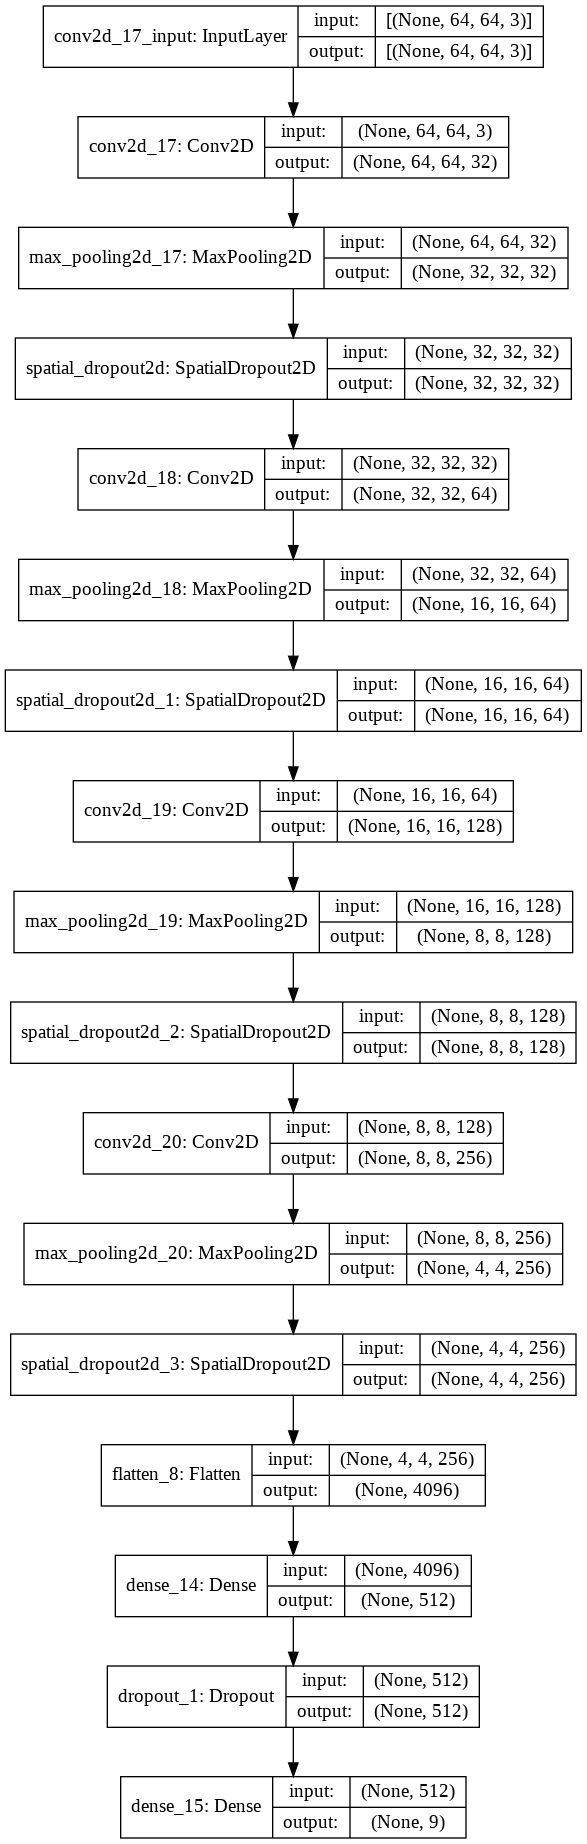

Epoch 1/70
600/600 [==============================] - 5s 7ms/step - loss: 2.1210 - accuracy: 0.1750 - val_loss: 1.7138 - val_accuracy: 0.3650
Epoch 2/70
600/600 [==============================] - 4s 7ms/step - loss: 1.7064 - accuracy: 0.3481 - val_loss: 1.6638 - val_accuracy: 0.3315
Epoch 3/70
600/600 [==============================] - 4s 7ms/step - loss: 1.5026 - accuracy: 0.4272 - val_loss: 1.2314 - val_accuracy: 0.5444
Epoch 4/70
600/600 [==============================] - 4s 7ms/step - loss: 1.3523 - accuracy: 0.4915 - val_loss: 1.1730 - val_accuracy: 0.5615
Epoch 5/70
600/600 [==============================] - 4s 7ms/step - loss: 1.2881 - accuracy: 0.5160 - val_loss: 1.1052 - val_accuracy: 0.5852
Epoch 6/70
600/600 [==============================] - 4s 7ms/step - loss: 1.1940 - accuracy: 0.5546 - val_loss: 1.0659 - val_accuracy: 0.5977
Epoch 7/70
600/600 [==============================] - 4s 7ms/step - loss: 1.1209 - accuracy: 0.5891 - val_loss: 1.0690 - val_accuracy: 0.5769
Epoch 

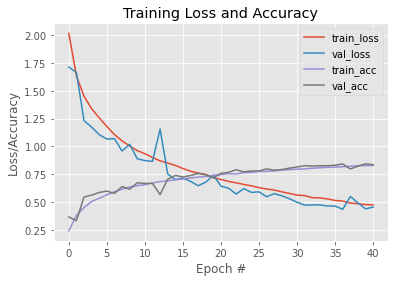

Model Performance Summary:
Best Validation Accuracy:  0.8427083492279053  at EPOCH: 39
Min validation loss: 0.4337461292743683  at EPOCH: 36


In [ ]:
call_model(CONV4_sp_d512_drop_CNN,get_basic_callback())

Model: "BaseLine_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


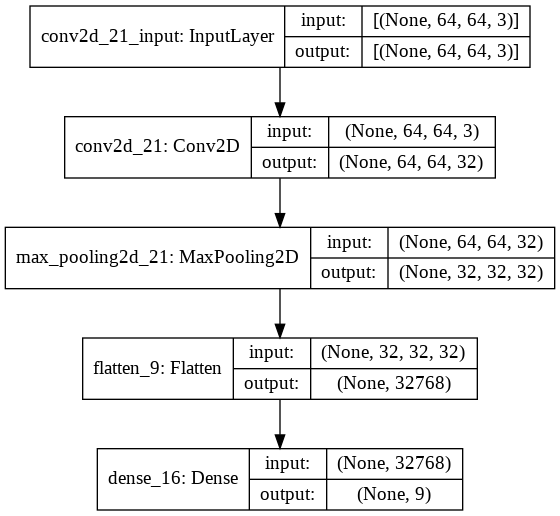

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 4ms/step - loss: 1.8432 - accuracy: 0.3105 - val_loss: 1.4679 - val_accuracy: 0.4321
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 2s 3ms/step - loss: 1.4263 - accuracy: 0.4714 - val_loss: 1.3457 - val_accuracy: 0.4869
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 2s 4ms/step - loss: 1.2766 - accuracy: 0.5360 - val_loss: 1.1678 - val_accuracy: 0.5660
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 2s 3ms/step - loss: 1.1264 - accuracy: 0.5906 - val_loss: 1.0519 - val_accuracy: 0.6527
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

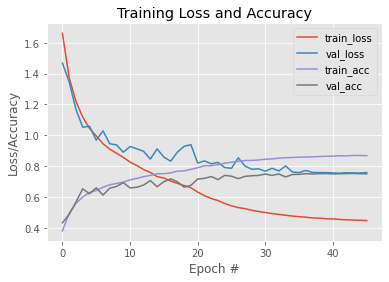

Model Performance Summary:
Best Validation Accuracy:  0.7516666650772095  at EPOCH: 43
Min validation loss: 0.7537392377853394  at EPOCH: 41


In [ ]:
call_model(BaseLine_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)


<Figure size 2880x720 with 0 Axes>

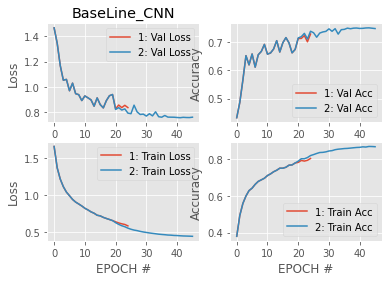

In [ ]:
compare_model_performance_with_lrs("BaseLine_CNN")

Model: "Baseline_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_18 (Dense)             (None, 9)                 4617      
Total params: 16,783,241
Trainable params: 16,783,241
Non-trainable params: 0
_________________________________________________________________
None


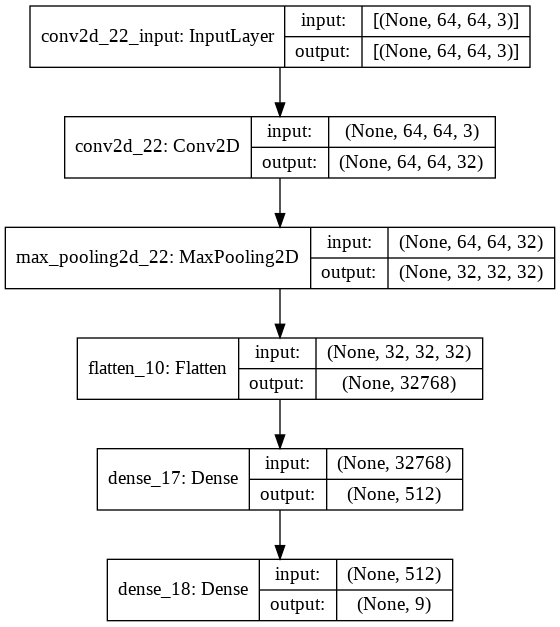

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.8403 - accuracy: 0.3097 - val_loss: 1.5204 - val_accuracy: 0.4242
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.4317 - accuracy: 0.4709 - val_loss: 1.3939 - val_accuracy: 0.4731
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.3033 - accuracy: 0.5224 - val_loss: 1.1363 - val_accuracy: 0.5835
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.1387 - accuracy: 0.5865 - val_loss: 1.0254 - val_accuracy: 0.6538
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

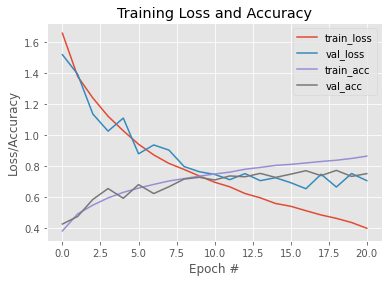

Model Performance Summary:
Best Validation Accuracy:  0.7714583277702332  at EPOCH: 18
Min validation loss: 0.6527037024497986  at EPOCH: 16


In [ ]:
call_model(Baseline_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)


<Figure size 2880x720 with 0 Axes>

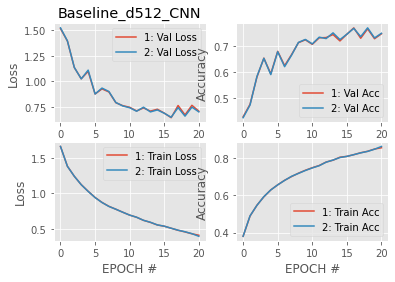

In [ ]:
compare_model_performance_with_lrs("Baseline_d512_CNN")

Model: "CONV2_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_34 (Dense)             (None, 9)              

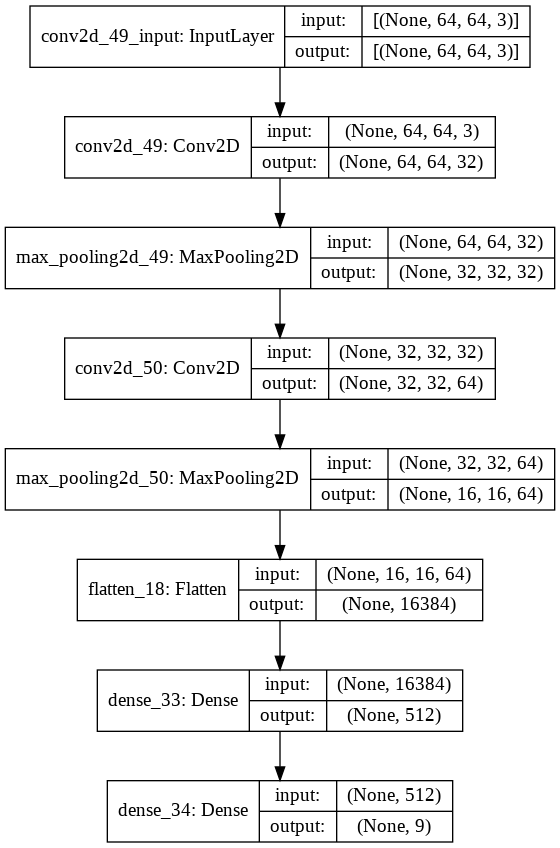

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 7ms/step - loss: 1.9013 - accuracy: 0.2822 - val_loss: 1.5253 - val_accuracy: 0.3983
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.4194 - accuracy: 0.4698 - val_loss: 1.4317 - val_accuracy: 0.4548
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.2554 - accuracy: 0.5420 - val_loss: 1.0521 - val_accuracy: 0.6152
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.0672 - accuracy: 0.6115 - val_loss: 0.9441 - val_accuracy: 0.6687
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

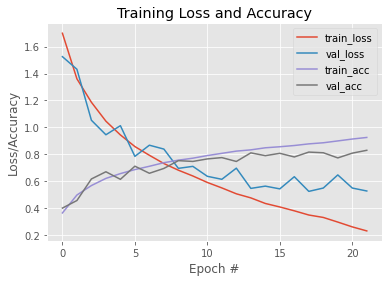

Model Performance Summary:
Best Validation Accuracy:  0.8285416960716248  at EPOCH: 21
Min validation loss: 0.5227847099304199  at EPOCH: 17


In [ ]:
call_model(CONV2_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)


<Figure size 2880x720 with 0 Axes>

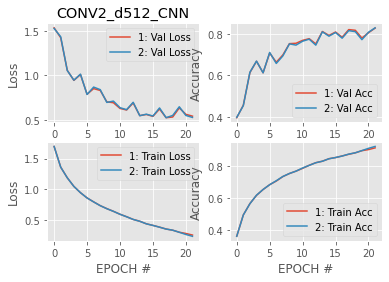

In [ ]:
compare_model_performance_with_lrs("CONV2_d512_CNN")

Model: "CONV3_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 8192)           

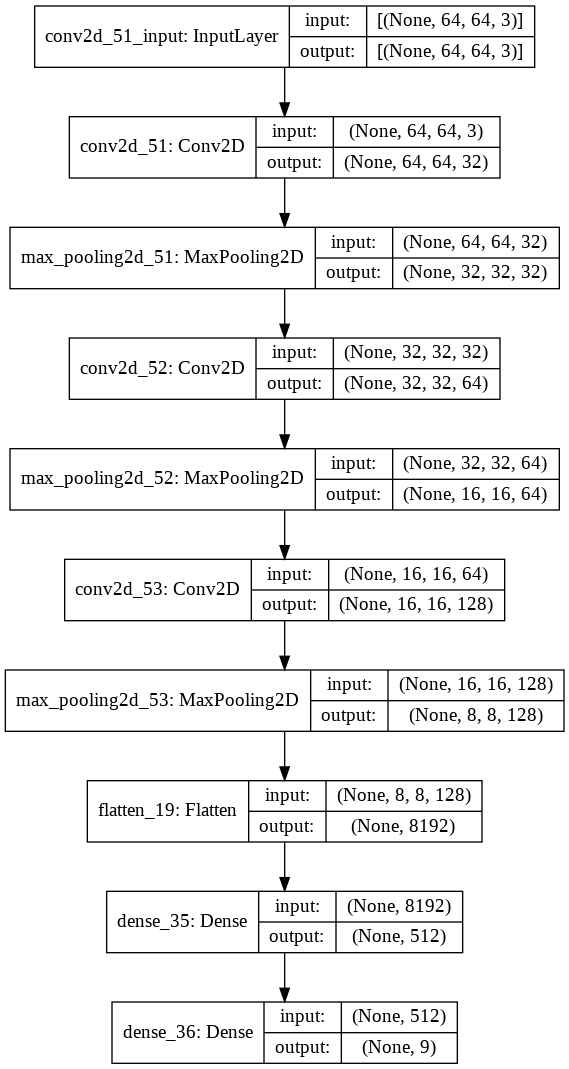

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.9822 - accuracy: 0.2609 - val_loss: 1.4815 - val_accuracy: 0.4402
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.4399 - accuracy: 0.4688 - val_loss: 1.4285 - val_accuracy: 0.4544
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.2728 - accuracy: 0.5333 - val_loss: 1.0985 - val_accuracy: 0.5817
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.0970 - accuracy: 0.6004 - val_loss: 0.9789 - val_accuracy: 0.6523
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

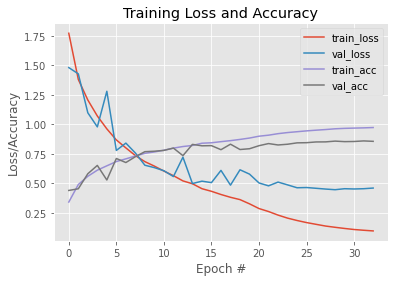

Model Performance Summary:
Best Validation Accuracy:  0.8600000143051147  at EPOCH: 31
Min validation loss: 0.4464550316333771  at EPOCH: 28


In [ ]:
call_model(CONV3_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

<Figure size 2880x720 with 0 Axes>

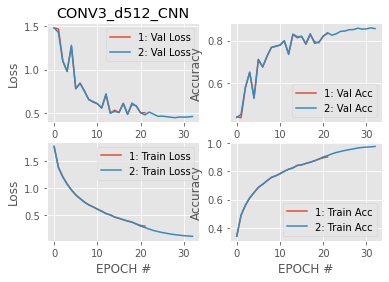

In [ ]:
compare_model_performance_with_lrs("CONV3_d512_CNN")

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 256)      

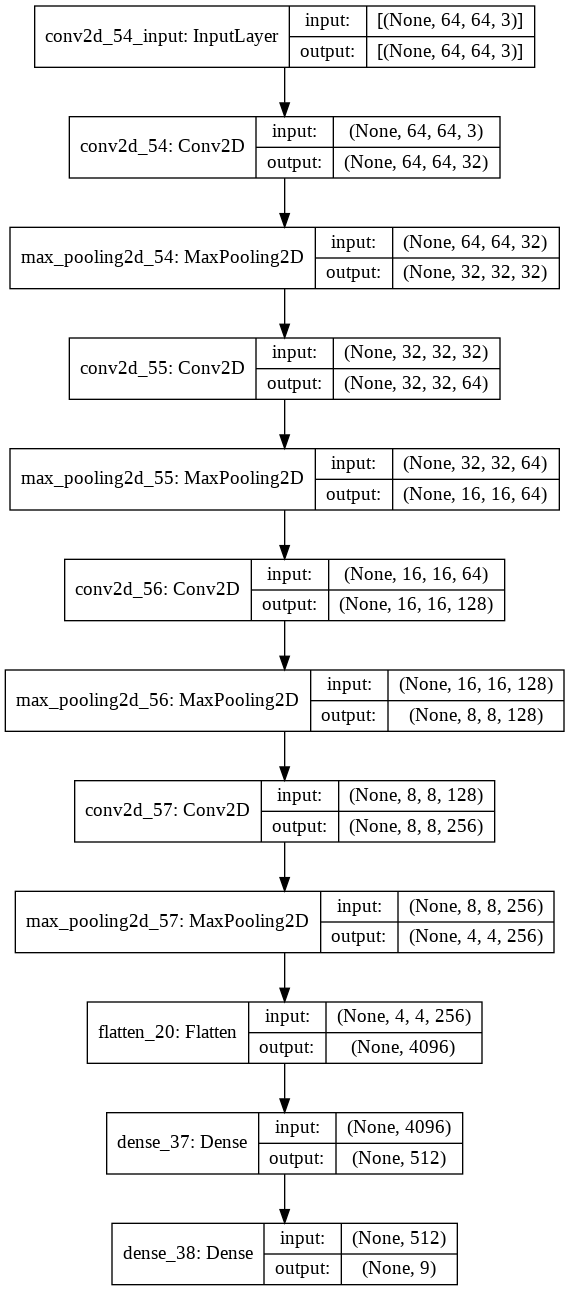

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 7ms/step - loss: 2.0483 - accuracy: 0.2109 - val_loss: 1.6094 - val_accuracy: 0.3500
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.5318 - accuracy: 0.4249 - val_loss: 1.6060 - val_accuracy: 0.3935
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.3305 - accuracy: 0.5113 - val_loss: 1.1512 - val_accuracy: 0.5673
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.1550 - accuracy: 0.5777 - val_loss: 1.1027 - val_accuracy: 0.6035
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

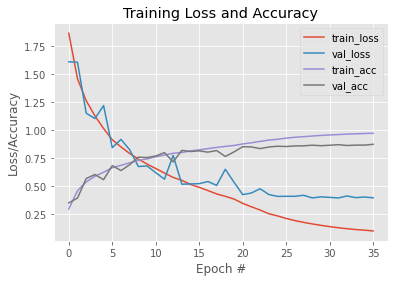

Model Performance Summary:
Best Validation Accuracy:  0.8731250166893005  at EPOCH: 35
Min validation loss: 0.39395204186439514  at EPOCH: 31


In [ ]:
call_model(CONV4_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)


<Figure size 2880x720 with 0 Axes>

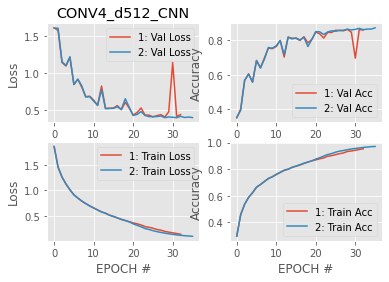

In [ ]:
compare_model_performance_with_lrs("CONV4_d512_CNN")

Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 8, 8, 256) 

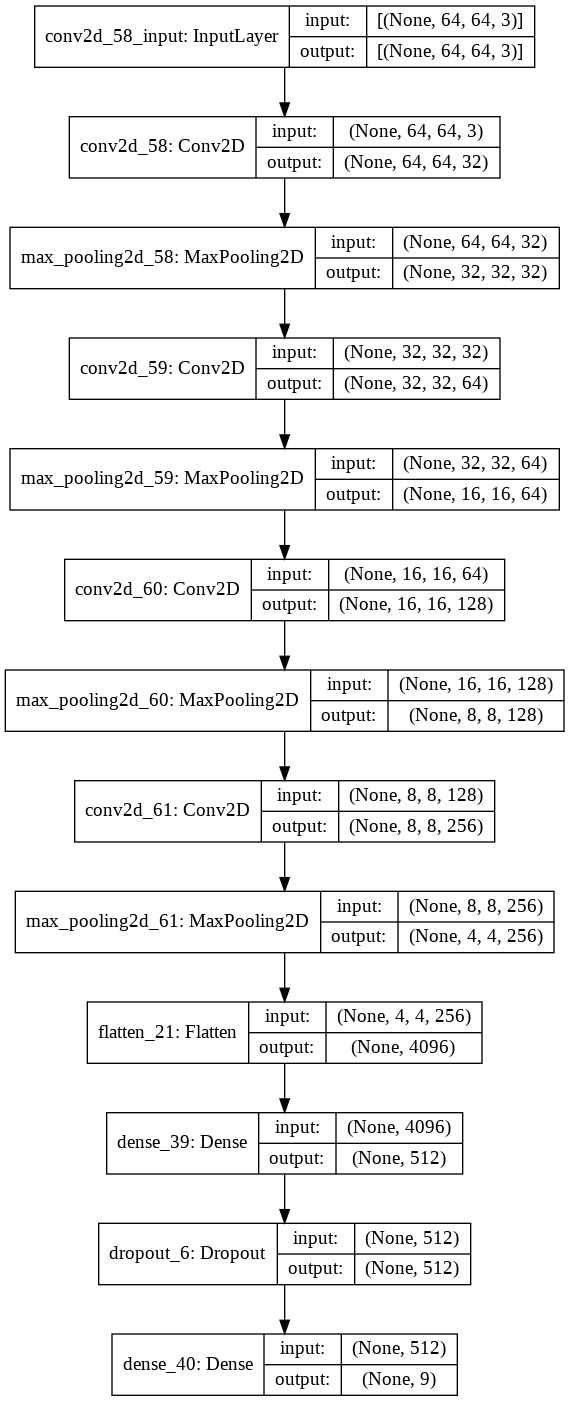

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 7ms/step - loss: 2.0529 - accuracy: 0.2079 - val_loss: 1.6070 - val_accuracy: 0.3519
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.5485 - accuracy: 0.4195 - val_loss: 1.6113 - val_accuracy: 0.3848
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.3500 - accuracy: 0.5022 - val_loss: 1.1360 - val_accuracy: 0.5692
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.1751 - accuracy: 0.5726 - val_loss: 1.0738 - val_accuracy: 0.6190
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

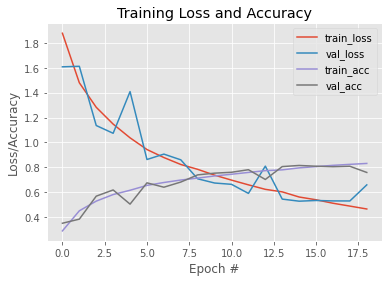

Model Performance Summary:
Best Validation Accuracy:  0.815625011920929  at EPOCH: 14
Min validation loss: 0.5288516879081726  at EPOCH: 14


In [ ]:
call_model(CONV4_d512_drop_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)


<Figure size 2880x720 with 0 Axes>

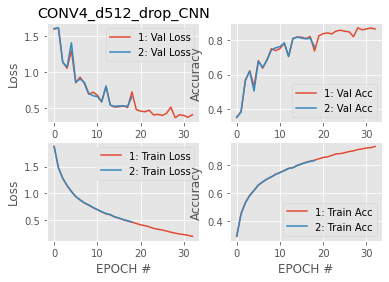

In [ ]:
compare_model_performance_with_lrs("CONV4_d512_drop_CNN")

Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_13 (Spatia (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 

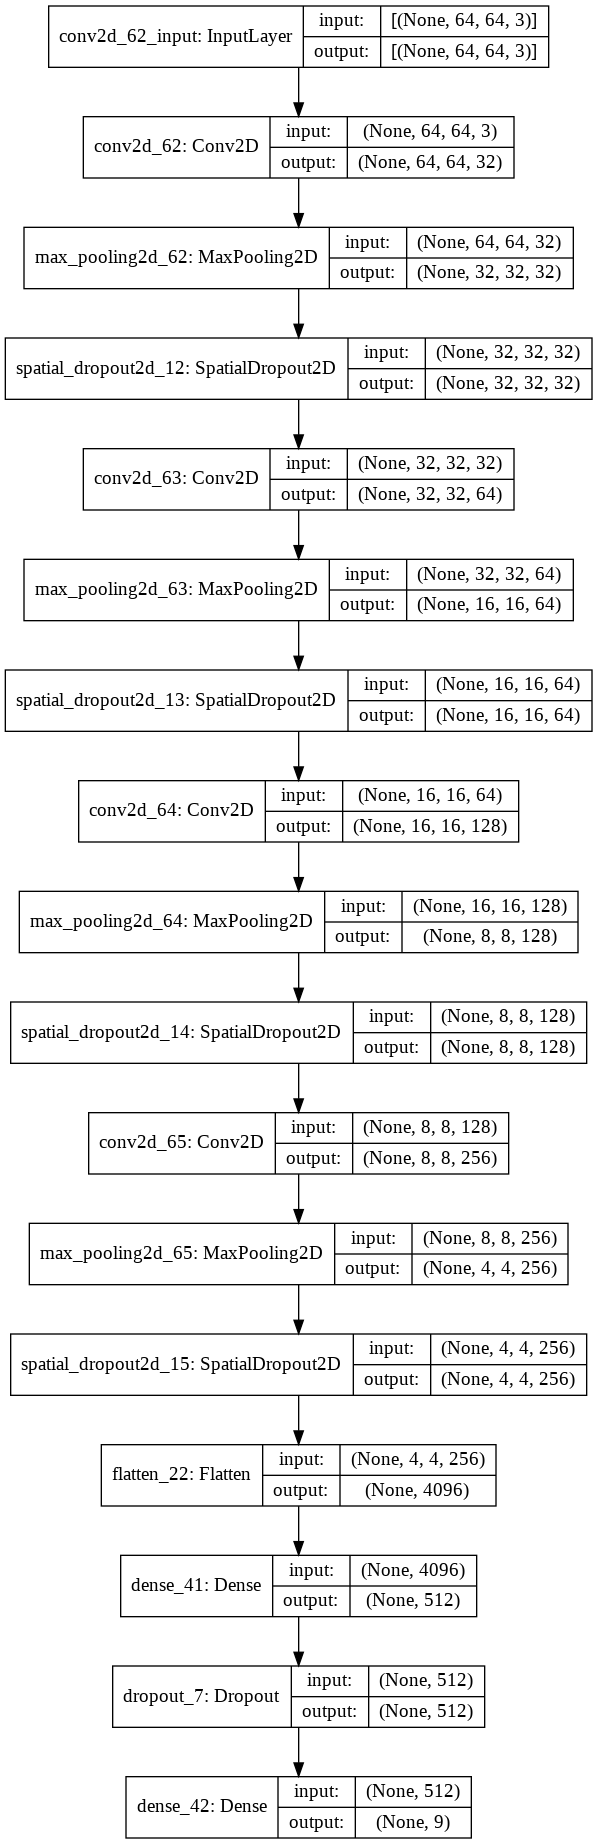

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 8ms/step - loss: 2.1211 - accuracy: 0.1749 - val_loss: 1.7132 - val_accuracy: 0.3675
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.7069 - accuracy: 0.3451 - val_loss: 1.6773 - val_accuracy: 0.3250
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.5030 - accuracy: 0.4258 - val_loss: 1.2297 - val_accuracy: 0.5481
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 7ms/step - loss: 1.3514 - accuracy: 0.4913 - val_loss: 1.1642 - val_accuracy: 0.5688
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

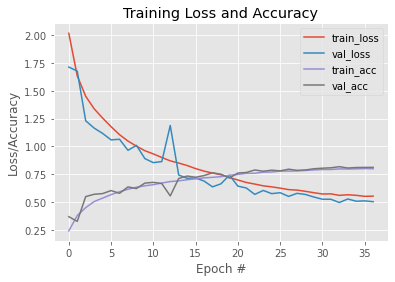

Model Performance Summary:
Best Validation Accuracy:  0.8170833587646484  at EPOCH: 32
Min validation loss: 0.4948924779891968  at EPOCH: 32


In [ ]:
call_model(CONV4_sp_d512_drop_CNN,get_basic_and_lrs_callback(), \
           model_history=g_record_v2)


<Figure size 2880x720 with 0 Axes>

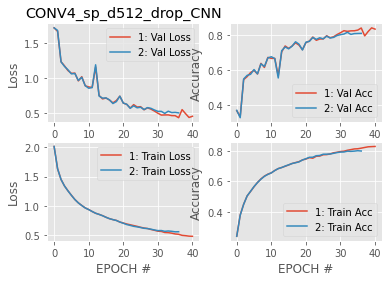

In [ ]:
compare_model_performance_with_lrs("CONV4_sp_d512_drop_CNN")

<Figure size 2880x720 with 0 Axes>

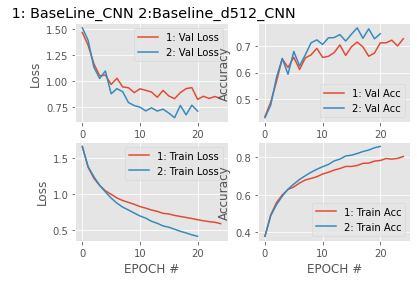

In [ ]:
compare_model_performance_with_another("BaseLine_CNN","Baseline_d512_CNN")

<Figure size 2880x720 with 0 Axes>

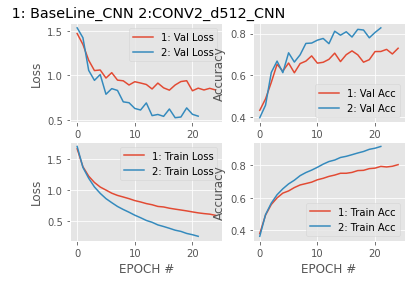

In [ ]:
compare_model_performance_with_another("BaseLine_CNN","CONV2_d512_CNN")

<Figure size 2880x720 with 0 Axes>

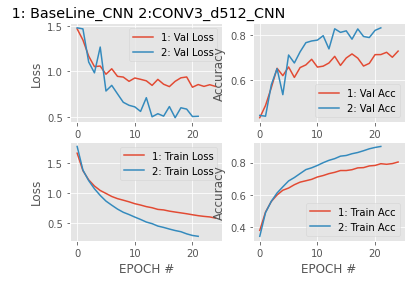

In [ ]:
compare_model_performance_with_another("BaseLine_CNN","CONV3_d512_CNN")

<Figure size 2880x720 with 0 Axes>

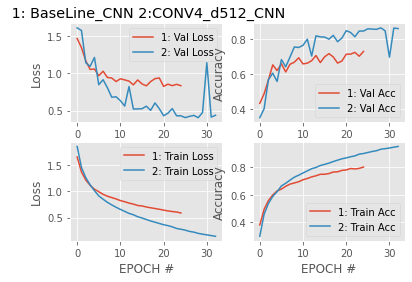

In [ ]:
compare_model_performance_with_another("BaseLine_CNN","CONV4_d512_CNN")

<Figure size 2880x720 with 0 Axes>

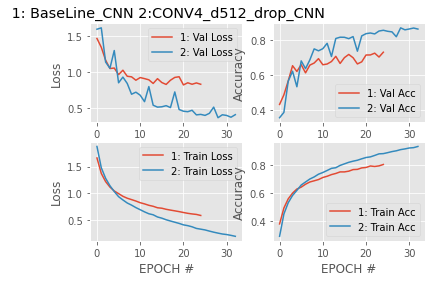

In [ ]:
compare_model_performance_with_another("BaseLine_CNN","CONV4_d512_drop_CNN")

<Figure size 2880x720 with 0 Axes>

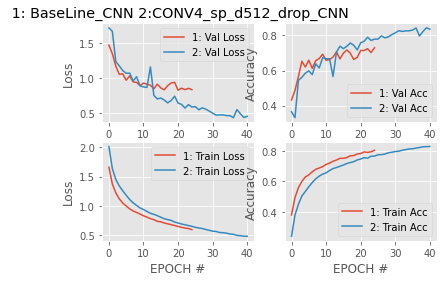

In [ ]:
compare_model_performance_with_another("BaseLine_CNN","CONV4_sp_d512_drop_CNN")

<Figure size 2880x720 with 0 Axes>

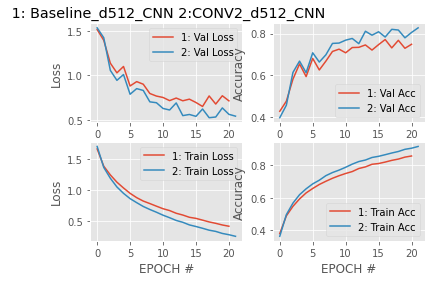

In [ ]:
compare_model_performance_with_another("Baseline_d512_CNN","CONV2_d512_CNN")

<Figure size 2880x720 with 0 Axes>

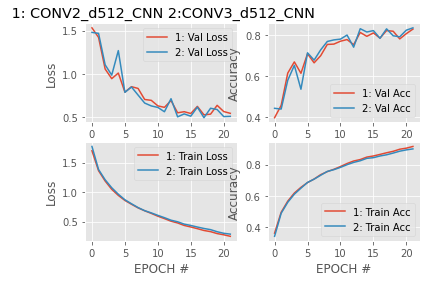

In [ ]:
compare_model_performance_with_another("CONV2_d512_CNN","CONV3_d512_CNN")

<Figure size 2880x720 with 0 Axes>

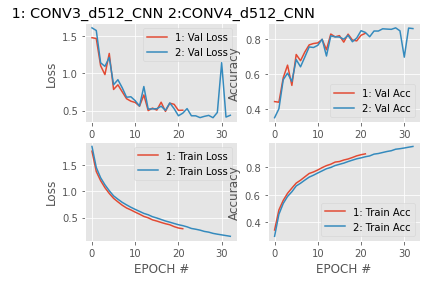

In [ ]:
compare_model_performance_with_another("CONV3_d512_CNN","CONV4_d512_CNN")

<Figure size 2880x720 with 0 Axes>

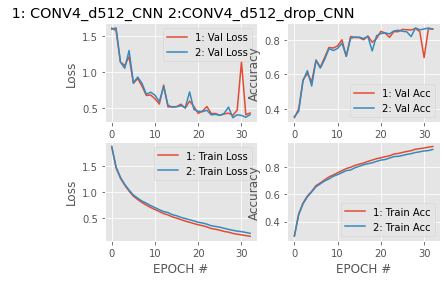

In [ ]:
compare_model_performance_with_another("CONV4_d512_CNN","CONV4_d512_drop_CNN")

<Figure size 2880x720 with 0 Axes>

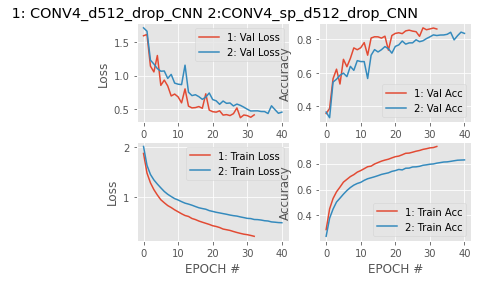

In [ ]:
compare_model_performance_with_another("CONV4_d512_drop_CNN","CONV4_sp_d512_drop_CNN")

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 256)      

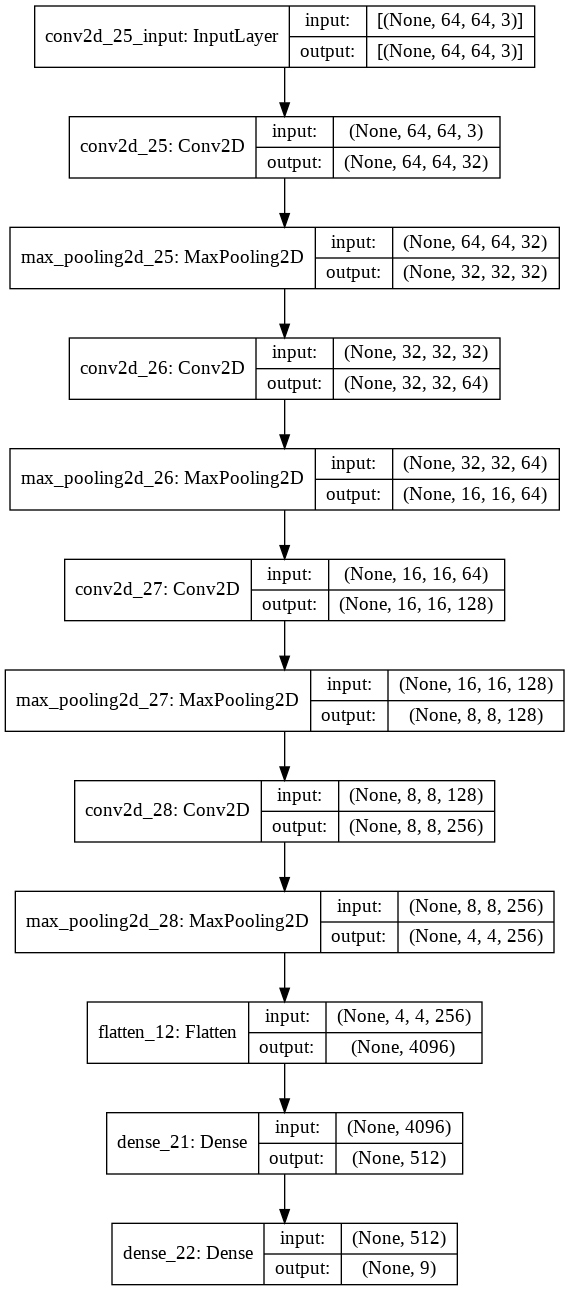

Epoch 1/70
600/600 [==============================] - 24s 39ms/step - loss: 2.0541 - accuracy: 0.2105 - val_loss: 1.6177 - val_accuracy: 0.4129
Epoch 2/70
600/600 [==============================] - 23s 38ms/step - loss: 1.5705 - accuracy: 0.4123 - val_loss: 1.3999 - val_accuracy: 0.4815
Epoch 3/70
600/600 [==============================] - 23s 38ms/step - loss: 1.3785 - accuracy: 0.4932 - val_loss: 1.1640 - val_accuracy: 0.5869
Epoch 4/70
600/600 [==============================] - 23s 38ms/step - loss: 1.2318 - accuracy: 0.5479 - val_loss: 1.1061 - val_accuracy: 0.6156
Epoch 5/70
600/600 [==============================] - 23s 38ms/step - loss: 1.1283 - accuracy: 0.5838 - val_loss: 0.9924 - val_accuracy: 0.6315
Epoch 6/70
600/600 [==============================] - 23s 38ms/step - loss: 1.0381 - accuracy: 0.6155 - val_loss: 0.9046 - val_accuracy: 0.6710
Epoch 7/70
600/600 [==============================] - 23s 38ms/step - loss: 0.9767 - accuracy: 0.6398 - val_loss: 0.9158 - val_accuracy:

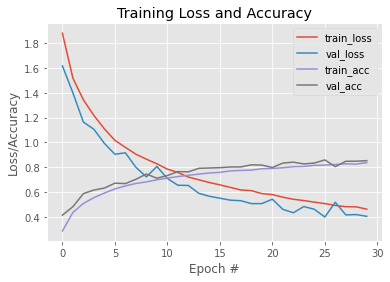

Model Performance Summary:
Best Validation Accuracy:  0.8587499856948853  at EPOCH: 25
Min validation loss: 0.3977617621421814  at EPOCH: 25


In [ ]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
call_model_with_augmentation(CONV4_d512_CNN,get_basic_callback(),\
                             generator_obj = train_generator_full)

<Figure size 2880x720 with 0 Axes>

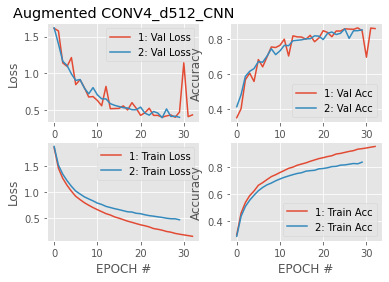

In [ ]:
compare_model_performance_with_augmentation("CONV4_d512_CNN")

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 256)      

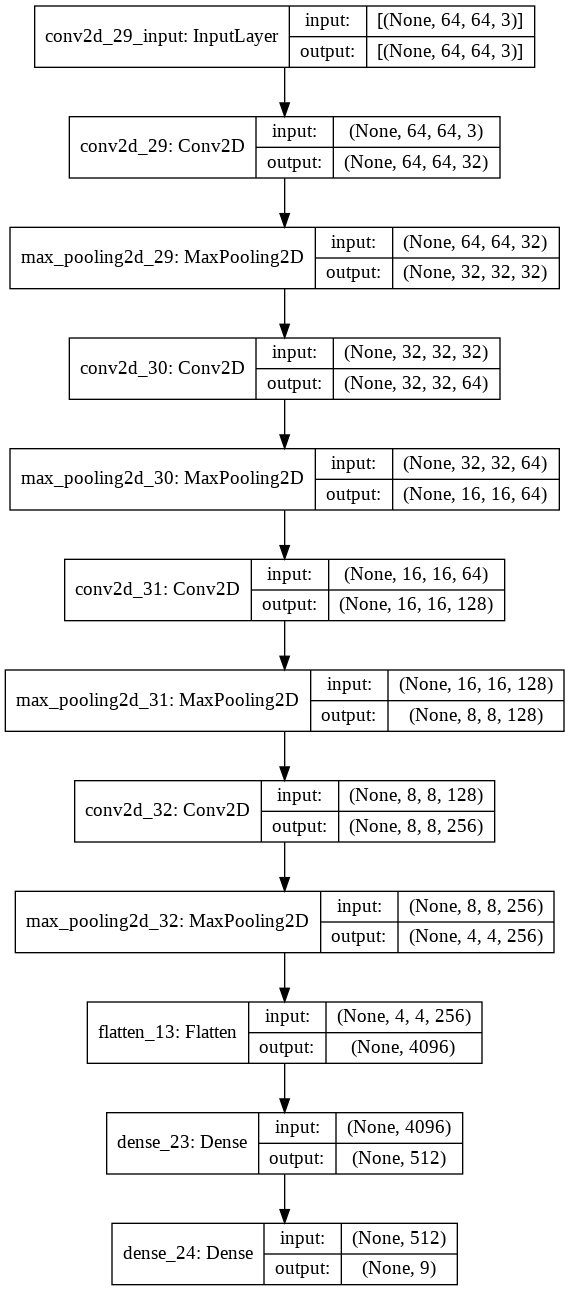

Epoch 1/70
600/600 [==============================] - 5s 8ms/step - loss: 2.0497 - accuracy: 0.2159 - val_loss: 1.5234 - val_accuracy: 0.4146
Epoch 2/70
600/600 [==============================] - 5s 8ms/step - loss: 1.5186 - accuracy: 0.4329 - val_loss: 1.3972 - val_accuracy: 0.4600
Epoch 3/70
600/600 [==============================] - 5s 8ms/step - loss: 1.3097 - accuracy: 0.5154 - val_loss: 1.3972 - val_accuracy: 0.4725
Epoch 4/70
600/600 [==============================] - 5s 8ms/step - loss: 1.1626 - accuracy: 0.5750 - val_loss: 1.2247 - val_accuracy: 0.5517
Epoch 5/70
600/600 [==============================] - 5s 8ms/step - loss: 1.0579 - accuracy: 0.6129 - val_loss: 0.8997 - val_accuracy: 0.6615
Epoch 6/70
600/600 [==============================] - 5s 8ms/step - loss: 0.9560 - accuracy: 0.6484 - val_loss: 1.0558 - val_accuracy: 0.6015
Epoch 7/70
600/600 [==============================] - 4s 7ms/step - loss: 0.8886 - accuracy: 0.6716 - val_loss: 0.8273 - val_accuracy: 0.6946
Epoch 

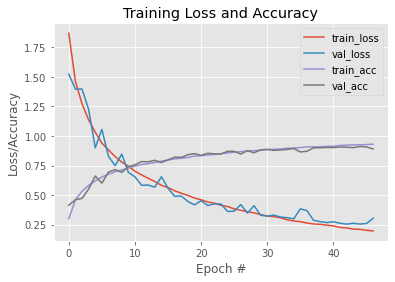

Model Performance Summary:
Best Validation Accuracy:  0.9118750095367432  at EPOCH: 44
Min validation loss: 0.2541428506374359  at EPOCH: 42


In [ ]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, g_trainY, \
                                                 batch_size=32)                        
 call_model_with_augmentation(CONV4_d512_CNN,get_basic_callback(),\
                             generator_obj = train_generator_flip)

<Figure size 2880x720 with 0 Axes>

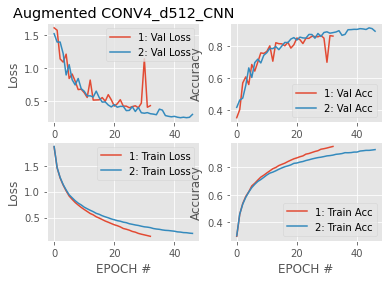

In [ ]:
compare_model_performance_with_augmentation("CONV4_d512_CNN")

Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 256) 

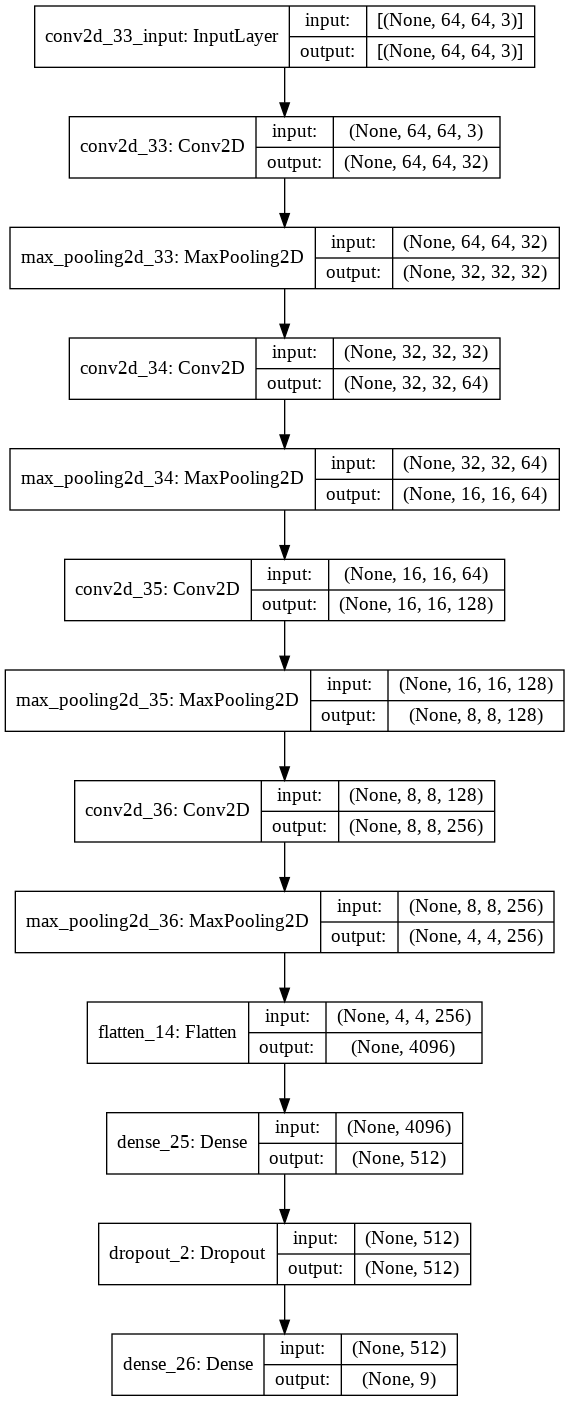

Epoch 1/70
600/600 [==============================] - 24s 39ms/step - loss: 2.0646 - accuracy: 0.2072 - val_loss: 1.5794 - val_accuracy: 0.4171
Epoch 2/70
600/600 [==============================] - 23s 38ms/step - loss: 1.5844 - accuracy: 0.4038 - val_loss: 1.3147 - val_accuracy: 0.5248
Epoch 3/70
600/600 [==============================] - 23s 38ms/step - loss: 1.4167 - accuracy: 0.4783 - val_loss: 1.2064 - val_accuracy: 0.5429
Epoch 4/70
600/600 [==============================] - 23s 38ms/step - loss: 1.2658 - accuracy: 0.5354 - val_loss: 1.0748 - val_accuracy: 0.6083
Epoch 5/70
600/600 [==============================] - 23s 38ms/step - loss: 1.1446 - accuracy: 0.5740 - val_loss: 1.1649 - val_accuracy: 0.5633
Epoch 6/70
600/600 [==============================] - 23s 38ms/step - loss: 1.0561 - accuracy: 0.6130 - val_loss: 1.5593 - val_accuracy: 0.4865
Epoch 7/70
600/600 [==============================] - 23s 38ms/step - loss: 1.0037 - accuracy: 0.6289 - val_loss: 0.8099 - val_accuracy:

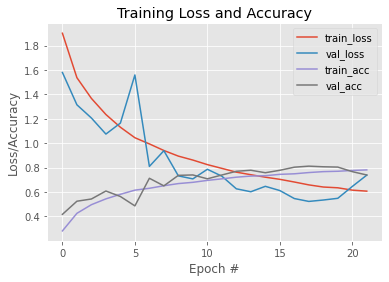

Model Performance Summary:
Best Validation Accuracy:  0.8120833039283752  at EPOCH: 17
Min validation loss: 0.523073673248291  at EPOCH: 17


In [ ]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
call_model_with_augmentation(CONV4_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_full)

<Figure size 2880x720 with 0 Axes>

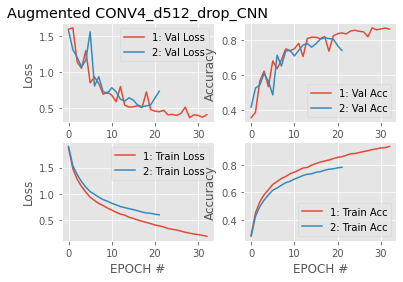

In [ ]:
compare_model_performance_with_augmentation("CONV4_d512_drop_CNN")

Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 256) 

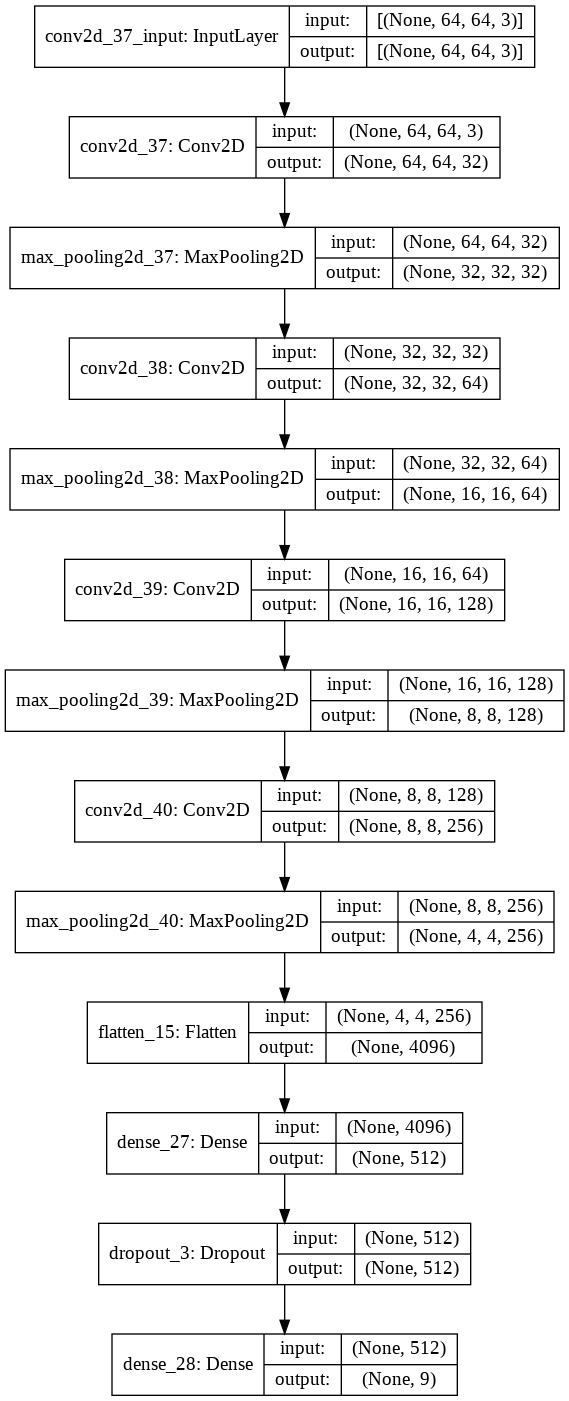

Epoch 1/70
600/600 [==============================] - 5s 8ms/step - loss: 2.0575 - accuracy: 0.2131 - val_loss: 1.6129 - val_accuracy: 0.3633
Epoch 2/70
600/600 [==============================] - 5s 8ms/step - loss: 1.5569 - accuracy: 0.4136 - val_loss: 1.3217 - val_accuracy: 0.4915
Epoch 3/70
600/600 [==============================] - 5s 8ms/step - loss: 1.3388 - accuracy: 0.5095 - val_loss: 1.4625 - val_accuracy: 0.4325
Epoch 4/70
600/600 [==============================] - 5s 8ms/step - loss: 1.1835 - accuracy: 0.5625 - val_loss: 1.0494 - val_accuracy: 0.6121
Epoch 5/70
600/600 [==============================] - 5s 8ms/step - loss: 1.0709 - accuracy: 0.6050 - val_loss: 1.1102 - val_accuracy: 0.5840
Epoch 6/70
600/600 [==============================] - 5s 8ms/step - loss: 0.9748 - accuracy: 0.6414 - val_loss: 0.7961 - val_accuracy: 0.7077
Epoch 7/70
600/600 [==============================] - 5s 8ms/step - loss: 0.9161 - accuracy: 0.6616 - val_loss: 0.8236 - val_accuracy: 0.6948
Epoch 

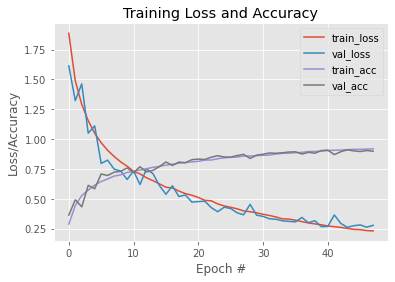

Model Performance Summary:
Best Validation Accuracy:  0.9100000262260437  at EPOCH: 43
Min validation loss: 0.2612067759037018  at EPOCH: 43


In [ ]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
 call_model_with_augmentation(CONV4_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_flip)

<Figure size 2880x720 with 0 Axes>

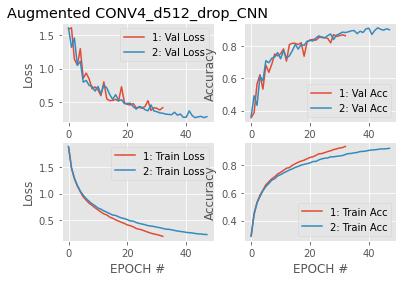

In [ ]:
compare_model_performance_with_augmentation("CONV4_d512_drop_CNN")

Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 

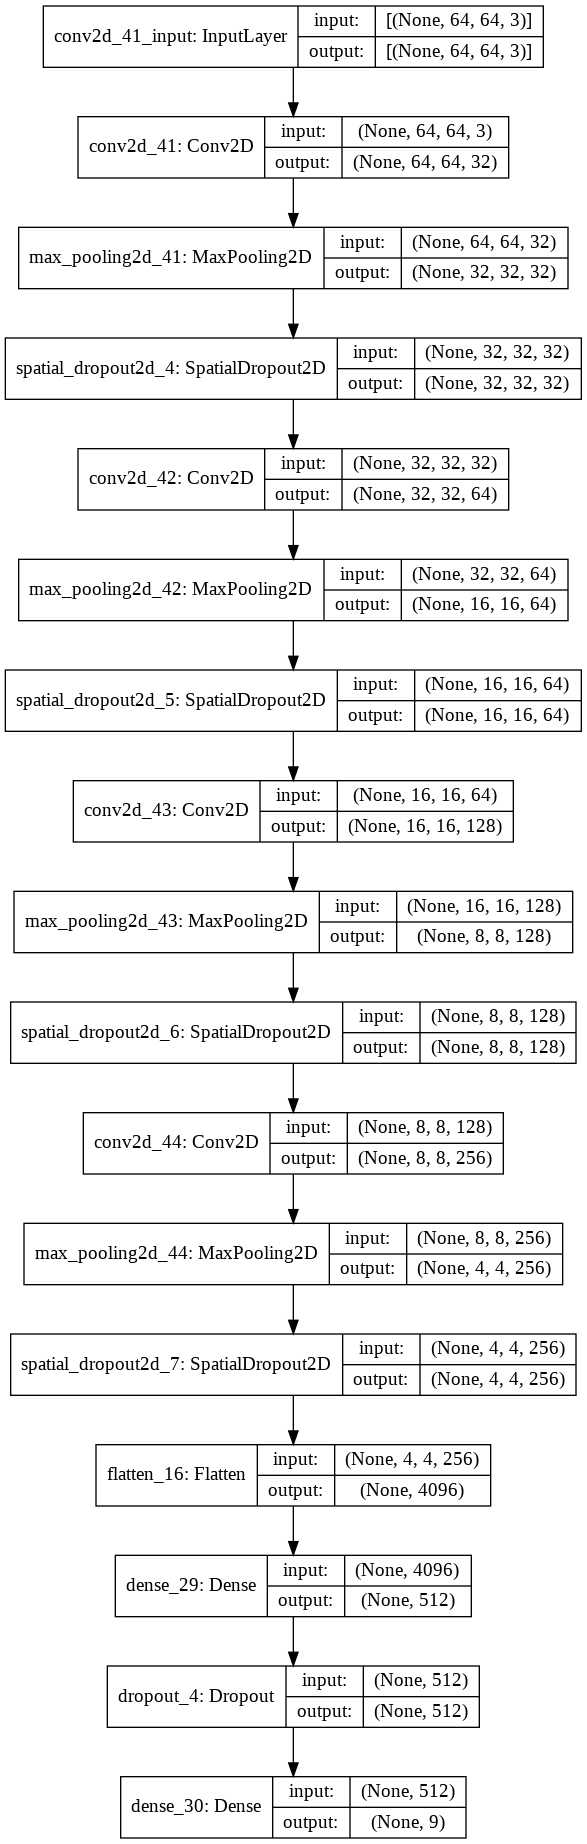

Epoch 1/70
600/600 [==============================] - 25s 40ms/step - loss: 2.1298 - accuracy: 0.1701 - val_loss: 1.7528 - val_accuracy: 0.3388
Epoch 2/70
600/600 [==============================] - 23s 39ms/step - loss: 1.7539 - accuracy: 0.3298 - val_loss: 1.4360 - val_accuracy: 0.4815
Epoch 3/70
600/600 [==============================] - 23s 39ms/step - loss: 1.5540 - accuracy: 0.4144 - val_loss: 1.3998 - val_accuracy: 0.4692
Epoch 4/70
600/600 [==============================] - 23s 39ms/step - loss: 1.4501 - accuracy: 0.4578 - val_loss: 1.2201 - val_accuracy: 0.5531
Epoch 5/70
600/600 [==============================] - 23s 39ms/step - loss: 1.3349 - accuracy: 0.5062 - val_loss: 1.1875 - val_accuracy: 0.5496
Epoch 6/70
600/600 [==============================] - 23s 39ms/step - loss: 1.2783 - accuracy: 0.5266 - val_loss: 1.0896 - val_accuracy: 0.5977
Epoch 7/70
600/600 [==============================] - 24s 39ms/step - loss: 1.2210 - accuracy: 0.5515 - val_loss: 1.0057 - val_accuracy:

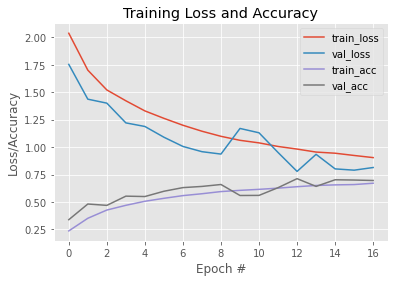

Model Performance Summary:
Best Validation Accuracy:  0.7122916579246521  at EPOCH: 12
Min validation loss: 0.7783823609352112  at EPOCH: 12


In [ ]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
call_model_with_augmentation(CONV4_sp_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_full)

<Figure size 2880x720 with 0 Axes>

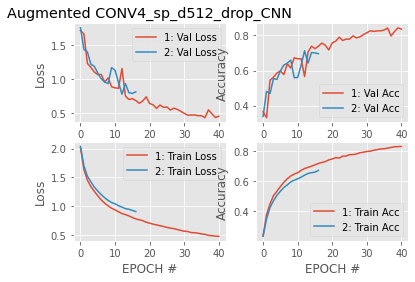

In [ ]:
compare_model_performance_with_augmentation("CONV4_sp_d512_drop_CNN")

Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_9 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 

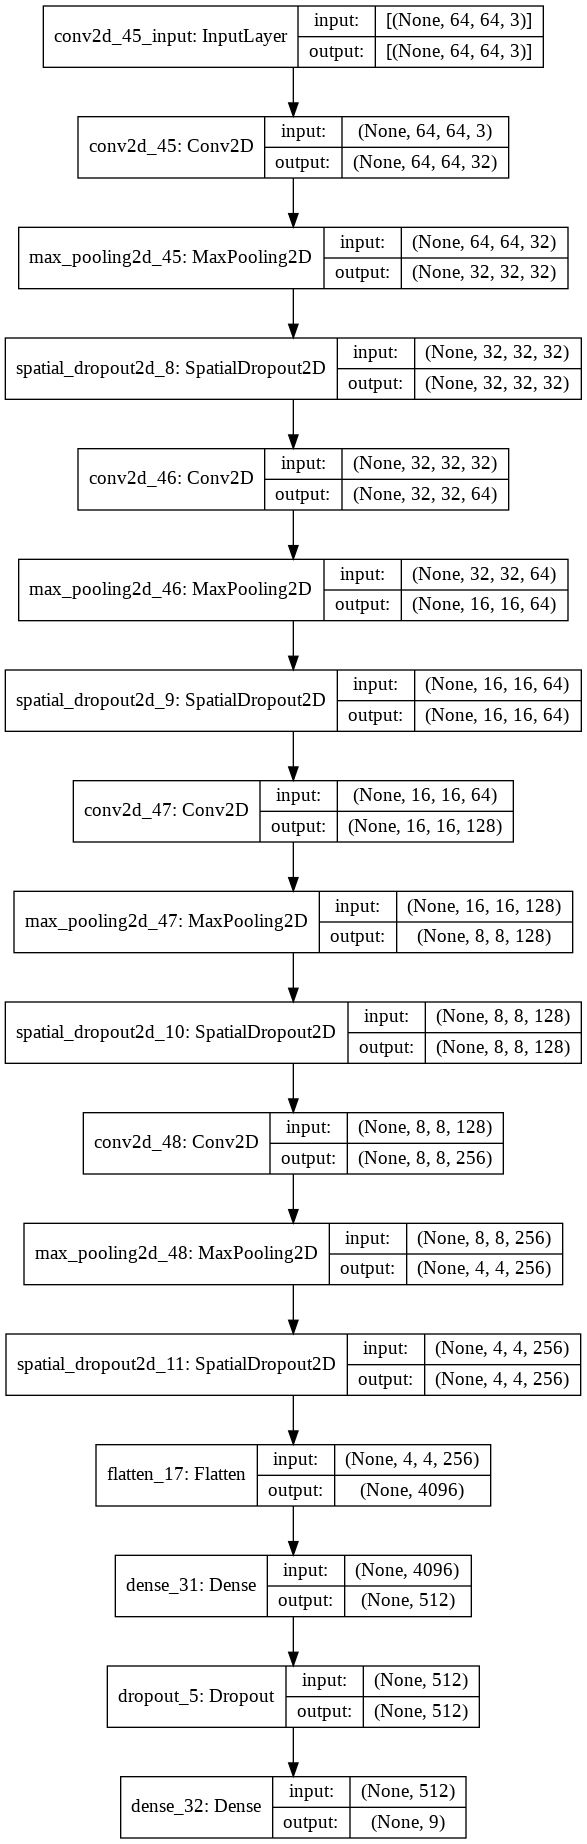

Epoch 1/70
600/600 [==============================] - 6s 9ms/step - loss: 2.1224 - accuracy: 0.1762 - val_loss: 1.7249 - val_accuracy: 0.3885
Epoch 2/70
600/600 [==============================] - 5s 8ms/step - loss: 1.7187 - accuracy: 0.3431 - val_loss: 1.4214 - val_accuracy: 0.4640
Epoch 3/70
600/600 [==============================] - 5s 8ms/step - loss: 1.4911 - accuracy: 0.4314 - val_loss: 1.3681 - val_accuracy: 0.4888
Epoch 4/70
600/600 [==============================] - 5s 8ms/step - loss: 1.3696 - accuracy: 0.4885 - val_loss: 1.1667 - val_accuracy: 0.5729
Epoch 5/70
600/600 [==============================] - 5s 8ms/step - loss: 1.2796 - accuracy: 0.5234 - val_loss: 1.2055 - val_accuracy: 0.5433
Epoch 6/70
600/600 [==============================] - 5s 8ms/step - loss: 1.2016 - accuracy: 0.5533 - val_loss: 1.0919 - val_accuracy: 0.5750
Epoch 7/70
600/600 [==============================] - 5s 8ms/step - loss: 1.1355 - accuracy: 0.5771 - val_loss: 1.0170 - val_accuracy: 0.6204
Epoch 

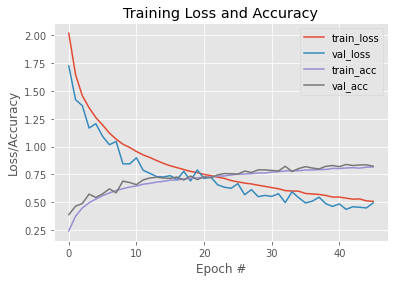

Model Performance Summary:
Best Validation Accuracy:  0.8393750190734863  at EPOCH: 41
Min validation loss: 0.4358593821525574  at EPOCH: 41


In [ ]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
 call_model_with_augmentation(CONV4_sp_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_flip)

<Figure size 2880x720 with 0 Axes>

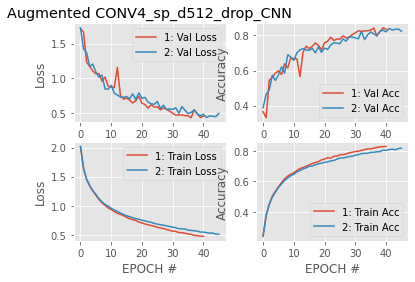

In [ ]:
compare_model_performance_with_augmentation("CONV4_sp_d512_drop_CNN")